In [1]:
!pip install opendatasets --upgrade --quiet
!pip install kaggle --quiet

# Import required libraries
import opendatasets as od
import os
import cv2
import numpy as np
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.models import Model
import tensorflow as tf
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report
import time

# Download dataset from Kaggle
dataset_url = 'https://www.kaggle.com/datasets/jiayuanchengala/aid-scene-classification-datasets'
od.download(dataset_url)

# Set the path to the image folder
data_path = 'aid-scene-classification-datasets/AID'

# Load and preprocess dataset
image_data = []
labels = []

for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith(".jpg"):
            image = cv2.imread(os.path.join(root, file))
            image = cv2.resize(image, (32, 32))
            image = img_to_array(image)
            image_data.append(image)
            label = root.split(os.path.sep)[-1]
            labels.append(label)

image_data = np.array(image_data, dtype="float") / 255.0
labels = np.array(labels)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)

x_train, x_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.2, random_state=42)
print(f'Training samples: {len(x_train)}, Testing samples: {len(x_test)}')

# Define Teacher Model
def teacher_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs)

# Define Student Model
def student_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs)

input_shape = (32, 32, 3)
num_classes = len(lb.classes_)

teacher = teacher_model(input_shape, num_classes)
student = student_model(input_shape, num_classes)

# Learning rate scheduler
def lr_scheduler(epoch, lr):
    return float(lr * tf.math.exp(-0.1)) if epoch >= 10 else float(lr)

# Train Teacher
teacher.compile(optimizer=SGD(learning_rate=1e-2, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
teacher.fit(x_train, y_train, batch_size=32, epochs=15, validation_data=(x_test, y_test), callbacks=[LearningRateScheduler(lr_scheduler)])

# Teacher Evaluation
teacher_score = teacher.evaluate(x_test, y_test, verbose=0)
print(f'Teacher test accuracy: {teacher_score[1] * 100:.2f}%')

# Teacher predictions (for distillation)
teacher_preds = teacher.predict(x_train)

# Distillation Loss Function (alpha=0.25)
def distillation_loss(y_true, y_pred, teacher_preds, temperature=3.0, alpha=0.25):
    teacher_batch_preds = tf.gather(teacher_preds, tf.range(tf.shape(y_pred)[0]))
    y_true_soft = tf.keras.activations.softmax(y_true / temperature)
    y_pred_soft = tf.keras.activations.softmax(y_pred / temperature)
    teacher_soft = tf.keras.activations.softmax(teacher_batch_preds / temperature)
    soft_loss = tf.keras.losses.categorical_crossentropy(teacher_soft, y_pred_soft)
    hard_loss = tf.keras.losses.categorical_crossentropy(y_true_soft, y_pred_soft)
    return alpha * soft_loss + (1. - alpha) * hard_loss

# Train Student
student.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=lambda y_true, y_pred: distillation_loss(y_true, y_pred, teacher_preds),
    metrics=['accuracy']
)
student.fit(x_train, y_train, batch_size=32, epochs=30, validation_data=(x_test, y_test), callbacks=[LearningRateScheduler(lr_scheduler)])

# Save trained models
teacher.save("teacher_model.h5")
student.save("student_model.h5")
print("Models saved successfully.")

# Evaluate Student on Clean Test Set
start_time = time.time()
y_pred_probs = student.predict(x_test)
inference_time = time.time() - start_time

y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\n=== Final Student Model Evaluation on Clean Test Set ===")
print(classification_report(y_true, y_pred, target_names=lb.classes_))
print(f"Inference Time: {inference_time:.4f} seconds")

# -----------------------------
# Robustness Evaluation Against Gaussian Noise
# -----------------------------

y_reference_probs = student.predict(x_test)
y_reference = np.argmax(y_reference_probs, axis=1)

# Lists to store results
stddev_values = np.linspace(0, 1, 20)
noisy_accuracies, noisy_f1_scores, noisy_precisions, noisy_recalls = [], [], [], []
y_reference_list = []
y_reference_probs_list = []
y_pred_noisy_probs_list = []
y_pred_noisy_list = []

for stddev in stddev_values:
    noise = np.random.normal(loc=0.0, scale=stddev, size=x_test.shape)
    x_noisy = np.clip(x_test + noise, 0., 1.)

    y_pred_noisy_probs = student.predict(x_noisy)
    y_pred_noisy = np.argmax(y_pred_noisy_probs, axis=1)

    acc = accuracy_score(y_reference, y_pred_noisy)
    f1 = f1_score(y_reference, y_pred_noisy, average='weighted')
    precision = precision_score(y_reference, y_pred_noisy, average='weighted')
    recall = recall_score(y_reference, y_pred_noisy, average='weighted')

    noisy_accuracies.append(acc)
    noisy_f1_scores.append(f1)
    noisy_precisions.append(precision)
    noisy_recalls.append(recall)

    # Store predictions and references
    y_reference_list.append(y_reference)
    y_reference_probs_list.append(y_reference_probs)
    y_pred_noisy_probs_list.append(y_pred_noisy_probs)
    y_pred_noisy_list.append(y_pred_noisy)

    print(f"Noise STDDEV = {stddev:.2f} -> Accuracy = {acc:.4f}, F1 = {f1:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Dataset URL: https://www.kaggle.com/datasets/jiayuanchengala/aid-scene-classification-datasets


100%|██████████| 2.45G/2.45G [00:25<00:00, 102MB/s]



Training samples: 8000, Testing samples: 2000
Epoch 1/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 105s 415ms/step - accuracy: 0.0499 - loss: 3.3501 - val_accuracy: 0.0915 - val_loss: 3.0202 - learning_rate: 0.0100
Epoch 2/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 144s 423ms/step - accuracy: 0.1645 - loss: 2.8070 - val_accuracy: 0.2810 - val_loss: 2.3634 - learning_rate: 0.0100
Epoch 3/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 104s 417ms/step - accuracy: 0.2905 - loss: 2.3374 - val_accuracy: 0.3780 - val_loss: 2.0281 - learning_rate: 0.0100
Epoch 4/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 147s 436ms/step - accuracy: 0.3844 - loss: 2.0459 - val_accuracy: 0.4640 - val_loss: 1.8056 - learning_rate: 0.0100
Epoch 5/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 109s 436ms/step - accuracy: 0.4467 - loss: 1.7948 - val_accuracy: 0.4770 - val_loss: 1.7114 - learning_rate: 0.0100
Epoch 6/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 136s 410ms/step - accuracy: 0.4879 - loss: 1.6542 - val_accuracy: 0.4600 - val_loss: 1.8414 - learning_rate: 0.0100
Epoch 7/15
250/25

Models saved successfully.
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step

=== Final Student Model Evaluation on Clean Test Set ===
                   precision    recall  f1-score   support

          Airport       0.57      0.58      0.58        77
         BareLand       0.79      0.81      0.80        59
    BaseballField       0.88      0.86      0.87        42
            Beach       0.87      0.89      0.88        80
           Bridge       0.89      0.79      0.84        63
           Center       0.66      0.61      0.63        54
           Church       0.65      0.58      0.61        52
       Commercial       0.51      0.49      0.50        88
 DenseResidential       0.57      0.84      0.68        86
           Desert       0.82      0.86      0.84        59
         Farmland       0.71      0.67      0.69        78
           Forest       0.88      0.93      0.90        40
       Industrial       0.42      0.46      0.44        85
           Meadow       0.90      0.85      0.87

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Noise STDDEV = 0.16 -> Accuracy = 0.3380, F1 = 0.2984, Precision = 0.4488, Recall = 0.3380


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Noise STDDEV = 0.21 -> Accuracy = 0.2345, F1 = 0.1931, Precision = 0.3782, Recall = 0.2345


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.26 -> Accuracy = 0.1880, F1 = 0.1444, Precision = 0.3262, Recall = 0.1880
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.32 -> Accuracy = 0.1475, F1 = 0.1074, Precision = 0.2807, Recall = 0.1475
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.37 -> Accuracy = 0.1195, F1 = 0.0802, Precision = 0.1333, Recall = 0.1195
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Noise STDDEV = 0.42 -> Accuracy = 0.0890, F1 = 0.0554, Precision = 0.1525, Recall = 0.0890


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Noise STDDEV = 0.47 -> Accuracy = 0.0865, F1 = 0.0461, Precision = 0.1483, Recall = 0.0865


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Noise STDDEV = 0.53 -> Accuracy = 0.0655, F1 = 0.0334, Precision = 0.0698, Recall = 0.0655


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.58 -> Accuracy = 0.0675, F1 = 0.0354, Precision = 0.1009, Recall = 0.0675
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step
Noise STDDEV = 0.63 -> Accuracy = 0.0665, F1 = 0.0320, Precision = 0.0665, Recall = 0.0665


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.68 -> Accuracy = 0.0565, F1 = 0.0242, Precision = 0.0519, Recall = 0.0565
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.74 -> Accuracy = 0.0505, F1 = 0.0179, Precision = 0.0126, Recall = 0.0505
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Noise STDDEV = 0.79 -> Accuracy = 0.0490, F1 = 0.0173, Precision = 0.0183, Recall = 0.0490


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.84 -> Accuracy = 0.0525, F1 = 0.0191, Precision = 0.0463, Recall = 0.0525
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.89 -> Accuracy = 0.0455, F1 = 0.0148, Precision = 0.0114, Recall = 0.0455
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.95 -> Accuracy = 0.0495, F1 = 0.0176, Precision = 0.0143, Recall = 0.0495
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Noise STDDEV = 1.00 -> Accuracy = 0.0405, F1 = 0.0124, Precision = 0.0084, Recall = 0.0405


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [2]:
print(y_reference_list)
print(y_reference_probs_list)
print(y_pred_noisy_probs_list)
print(y_pred_noisy_list)

[array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3])]
[array([[2.03824490e-02, 1.67230645e-03, 3.28308460e-03, ...,
        1.21595897e-02, 3.65753584e-02, 5.86824317e-04],
       [2.82408932e-04, 2.22162740e-07, 1.86388046e-04, ...,
        3.34154338e-01, 2.85636797e-03, 4.03860431e-05],
  

In [3]:
import csv

In [7]:
with open('y_reference_list.csv','w',newline='') as file:
  writer=csv.writer(file)
  writer.writerow(y_reference_list)

In [9]:
import os
import cv2
import numpy as np
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.callbacks import LearningRateScheduler
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report
import time
import tensorflow as tf

# Define distillation loss function if needed (dummy placeholder here)
def distillation_loss(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred)

# Load models from .h5 files without compiling, then compile manually
teacher = tf.keras.models.load_model('teacher_model.h5', compile=False)
teacher.compile(optimizer=tf.keras.optimizers.SGD(), loss='categorical_crossentropy', metrics=['accuracy'])

student = tf.keras.models.load_model('student_model.h5', compile=False)
student.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                loss='categorical_crossentropy', metrics=['accuracy'])

# Assuming you already have preprocessed data ready in x_test and y_test
# If not, load your data here:
data_path = 'aid-scene-classification-datasets/AID'  # adjust path as needed
image_data = []
labels = []

for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith(".jpg"):
            image = cv2.imread(os.path.join(root, file))
            image = cv2.resize(image, (32, 32))
            image = img_to_array(image)
            image_data.append(image)
            label = root.split(os.path.sep)[-1]
            labels.append(label)

image_data = np.array(image_data, dtype="float") / 255.0
labels = np.array(labels)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)

x_train, x_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.2, random_state=42)

# Evaluate Teacher Model
teacher_score = teacher.evaluate(x_test, y_test, verbose=0)
print(f'Teacher test accuracy: {teacher_score[1] * 100:.2f}%')

# Teacher predictions (for distillation)
teacher_preds = teacher.predict(x_train)

# Student Evaluation on Clean Test Set
start_time = time.time()
y_pred_probs = student.predict(x_test)
inference_time = time.time() - start_time

y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\n=== Final Student Model Evaluation on Clean Test Set ===")
print(classification_report(y_true, y_pred, target_names=lb.classes_))
print(f"Inference Time: {inference_time:.4f} seconds")

# Robustness Evaluation Against Gaussian Noise
y_reference_probs = student.predict(x_test)
y_reference = np.argmax(y_reference_probs, axis=1)

stddev_values = np.linspace(0, 1, 20)

for stddev in stddev_values:
    noise = np.random.normal(loc=0.0, scale=stddev, size=x_test.shape)
    x_noisy = np.clip(x_test + noise, 0., 1.)

    y_pred_noisy_probs = student.predict(x_noisy)
    y_pred_noisy = np.argmax(y_pred_noisy_probs, axis=1)

    acc = accuracy_score(y_reference, y_pred_noisy)
    f1 = f1_score(y_reference, y_pred_noisy, average='weighted')
    precision = precision_score(y_reference, y_pred_noisy, average='weighted')
    recall = recall_score(y_reference, y_pred_noisy, average='weighted')

    print(f"Noise STDDEV = {stddev:.2f} -> Accuracy = {acc:.4f}, F1 = {f1:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}")

Teacher test accuracy: 62.75%
250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 93ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step

=== Final Student Model Evaluation on Clean Test Set ===
                   precision    recall  f1-score   support

          Airport       0.57      0.58      0.58        77
         BareLand       0.79      0.81      0.80        59
    BaseballField       0.88      0.86      0.87        42
            Beach       0.87      0.89      0.88        80
           Bridge       0.89      0.79      0.84        63
           Center       0.66      0.61      0.63        54
           Church       0.65      0.58      0.61        52
       Commercial       0.51      0.49      0.50        88
 DenseResidential       0.57      0.84      0.68        86
           Desert       0.82      0.86      0.84        59
         Farmland       0.71      0.67      0.69        78
           Forest       0.88      0.93      0.90        40
       Industrial       0.42      0.46      0.44        85
  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.21 -> Accuracy = 0.2420, F1 = 0.1945, Precision = 0.3430, Recall = 0.2420
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Noise STDDEV = 0.26 -> Accuracy = 0.1825, F1 = 0.1367, Precision = 0.2951, Recall = 0.1825


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Noise STDDEV = 0.32 -> Accuracy = 0.1525, F1 = 0.1098, Precision = 0.2340, Recall = 0.1525


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.37 -> Accuracy = 0.1080, F1 = 0.0712, Precision = 0.1716, Recall = 0.1080
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.42 -> Accuracy = 0.0975, F1 = 0.0602, Precision = 0.1148, Recall = 0.0975
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Noise STDDEV = 0.47 -> Accuracy = 0.0870, F1 = 0.0530, Precision = 0.1357, Recall = 0.0870


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.53 -> Accuracy = 0.0700, F1 = 0.0384, Precision = 0.1104, Recall = 0.0700
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.58 -> Accuracy = 0.0695, F1 = 0.0359, Precision = 0.1219, Recall = 0.0695
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.63 -> Accuracy = 0.0640, F1 = 0.0303, Precision = 0.0575, Recall = 0.0640
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.68 -> Accuracy = 0.0560, F1 = 0.0251, Precision = 0.0530, Recall = 0.0560
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.74 -> Accuracy = 0.0515, F1 = 0.0184, Precision = 0.0306, Recall = 0.0515
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Noise STDDEV = 0.79 -> Accuracy = 0.0540, F1 = 0.0163, Precision = 0.0105, Recall = 0.0540


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.84 -> Accuracy = 0.0490, F1 = 0.0193, Precision = 0.0477, Recall = 0.0490
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step
Noise STDDEV = 0.89 -> Accuracy = 0.0565, F1 = 0.0223, Precision = 0.0566, Recall = 0.0565


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Noise STDDEV = 0.95 -> Accuracy = 0.0490, F1 = 0.0198, Precision = 0.0628, Recall = 0.0490


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Noise STDDEV = 1.00 -> Accuracy = 0.0475, F1 = 0.0166, Precision = 0.0318, Recall = 0.0475


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [10]:
print(y_reference_list)
print(y_reference_probs_list)
print(y_pred_noisy_probs_list)
print(y_pred_noisy_list)

[array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3])]
[array([[2.03824490e-02, 1.67230645e-03, 3.28308460e-03, ...,
        1.21595897e-02, 3.65753584e-02, 5.86824317e-04],
       [2.82408932e-04, 2.22162740e-07, 1.86388046e-04, ...,
        3.34154338e-01, 2.85636797e-03, 4.03860431e-05],
  

In [14]:
import os
import cv2
import numpy as np
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report
import time
import tensorflow as tf
from keras.callbacks import LearningRateScheduler

# Load models from .h5 files without compiling
teacher_1 = tf.keras.models.load_model('teacher_model_1.h5', compile=False)
student_1 = tf.keras.models.load_model('student_model_1.h5', compile=False)

# Load and preprocess data
data_path = 'aid-scene-classification-datasets/AID'
image_data = []
labels = []

for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith(".jpg"):
            image = cv2.imread(os.path.join(root, file))
            image = cv2.resize(image, (32, 32))
            image = img_to_array(image)
            image_data.append(image)
            label = root.split(os.path.sep)[-1]
            labels.append(label)

image_data = np.array(image_data, dtype="float") / 255.0
labels = np.array(labels)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)

x_train, x_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.2, random_state=42)

# Get teacher predictions for distillation
teacher_preds_1 = teacher_1.predict(x_train)

# Define distillation loss function with nuclear norm
def distillation_loss(y_true, y_pred, teacher_preds, temperature=3.0, alpha=0.25):
    teacher_batch_preds = tf.gather(teacher_preds, tf.range(tf.shape(y_pred)[0]))
    y_true_soft = tf.keras.activations.softmax(y_true / temperature)
    y_pred_soft = tf.keras.activations.softmax(y_pred / temperature)
    teacher_soft = tf.keras.activations.softmax(teacher_batch_preds / temperature)
    soft_loss = tf.keras.losses.categorical_crossentropy(teacher_soft, y_pred_soft)
    hard_loss = tf.keras.losses.categorical_crossentropy(y_true_soft, y_pred_soft)

    first_layer_weights = None
    for layer in student_1.layers:
        if layer.weights:
            first_layer_weights = layer.weights[0]
            break

    if first_layer_weights is not None:
        singular_values = tf.linalg.svd(first_layer_weights, compute_uv=False)
        nuclear_norm = tf.reduce_sum(singular_values)
    else:
        nuclear_norm = 0.

    return alpha * (soft_loss + 0.001 * nuclear_norm) + (1. - alpha) * hard_loss

def lr_scheduler(epoch, lr):
    return float(lr * tf.math.exp(-0.1)) if epoch >= 10 else float(lr)

# Compile student model with custom loss
student_1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=lambda y_true, y_pred: distillation_loss(y_true, y_pred, teacher_preds_1),
    metrics=['accuracy']
)

# Retrain student model (if needed)
student_1.fit(x_train, y_train, batch_size=32, epochs=30, validation_data=(x_test, y_test), callbacks=[LearningRateScheduler(lr_scheduler)])

# Evaluate student on clean test set
start_time = time.time()
y_pred_probs = student_1.predict(x_test)
inference_time = time.time() - start_time

y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\n=== Final Student Model Evaluation on Clean Test Set ===")
print(classification_report(y_true, y_pred, target_names=lb.classes_))
print(f"Inference Time: {inference_time:.4f} seconds")

# Robustness evaluation
y_reference_probs_1 = student_1.predict(x_test)
y_reference_1 = np.argmax(y_reference_probs_1, axis=1)

# stddev_values = np.linspace(0, 1, 20)

# for stddev in stddev_values:
#     noise = np.random.normal(loc=0.0, scale=stddev, size=x_test.shape)
#     x_noisy = np.clip(x_test + noise, 0., 1.)

#     y_pred_noisy_probs_1 = student_1.predict(x_noisy)
#     y_pred_noisy_1 = np.argmax(y_pred_noisy_probs_1, axis=1)

#     acc = accuracy_score(y_reference_1, y_pred_noisy_1)
#     f1 = f1_score(y_reference_1, y_pred_noisy_1, average='weighted')
#     precision = precision_score(y_reference_1, y_pred_noisy_1, average='weighted')
#     recall = recall_score(y_reference_1, y_pred_noisy_1, average='weighted')

#     print(f"Noise STDDEV = {stddev:.2f} -> Accuracy = {acc:.4f}, F1 = {f1:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}")

stddev_values = np.linspace(0, 1, 20)
noisy_accuracies, noisy_f1_scores, noisy_precisions, noisy_recalls = [], [], [], []
y_reference_list_1 = []
y_reference_probs_list_1 = []
y_pred_noisy_probs_list_1 = []
y_pred_noisy_list_1 = []

for stddev in stddev_values:
    noise = np.random.normal(loc=0.0, scale=stddev, size=x_test.shape)
    x_noisy = np.clip(x_test + noise, 0., 1.)

    y_pred_noisy_probs_1 = student_1.predict(x_noisy) ########
    y_pred_noisy_1 = np.argmax(y_pred_noisy_probs_1, axis=1)

    acc = accuracy_score(y_reference_1, y_pred_noisy_1)
    f1 = f1_score(y_reference_1, y_pred_noisy_1, average='weighted')
    precision = precision_score(y_reference_1, y_pred_noisy_1, average='weighted')
    recall = recall_score(y_reference_1, y_pred_noisy_1, average='weighted')

    noisy_accuracies.append(acc)
    noisy_f1_scores.append(f1)
    noisy_precisions.append(precision)
    noisy_recalls.append(recall)

    y_reference_list_1.append(y_reference_1)
    y_reference_probs_list_1.append(y_reference_probs_1)
    y_pred_noisy_probs_list_1.append(y_pred_noisy_probs_1)
    y_pred_noisy_list_1.append(y_pred_noisy_1)

    print(f"Noise STDDEV = {stddev:.2f} -> Accuracy = {acc:.4f}, F1 = {f1:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}")
# print(y_reference_list_1)
# print(y_reference_probs_list_1)
# print(y_pred_noisy_probs_list_1)
# print(y_pred_noisy_list_1)

250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step
Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - accuracy: 0.8129 - loss: 3.4037 - val_accuracy: 0.6135 - val_loss: 3.4023 - learning_rate: 0.0010
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 38s 120ms/step - accuracy: 0.7671 - loss: 3.4018 - val_accuracy: 0.5995 - val_loss: 3.4014 - learning_rate: 0.0010
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 38s 109ms/step - accuracy: 0.7154 - loss: 3.4011 - val_accuracy: 0.5855 - val_loss: 3.4011 - learning_rate: 0.0010
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 39s 102ms/step - accuracy: 0.6813 - loss: 3.4009 - val_accuracy: 0.5650 - val_loss: 3.4010 - learning_rate: 0.0010
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 100ms/step - accuracy: 0.6930 - loss: 3.4008 - val_accuracy: 0.5325 - val_loss: 3.4010 - learning_rate: 0.0010
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 43s 109ms/step - accuracy: 0.7043 - loss: 3.4008 - val_accuracy: 0.5720 - val_loss: 3.4009 - learning_rate: 0.0010
Epoch 7/30
250/250 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.11 -> Accuracy = 0.4785, F1 = 0.4626, Precision = 0.5561, Recall = 0.4785
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Noise STDDEV = 0.16 -> Accuracy = 0.3385, F1 = 0.3144, Precision = 0.4564, Recall = 0.3385


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.21 -> Accuracy = 0.2480, F1 = 0.2097, Precision = 0.3800, Recall = 0.2480
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step
Noise STDDEV = 0.26 -> Accuracy = 0.1955, F1 = 0.1529, Precision = 0.2691, Recall = 0.1955


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.32 -> Accuracy = 0.1610, F1 = 0.1254, Precision = 0.2578, Recall = 0.1610
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
Noise STDDEV = 0.37 -> Accuracy = 0.1360, F1 = 0.0973, Precision = 0.1865, Recall = 0.1360


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.42 -> Accuracy = 0.1180, F1 = 0.0850, Precision = 0.1442, Recall = 0.1180
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step
Noise STDDEV = 0.47 -> Accuracy = 0.0890, F1 = 0.0540, Precision = 0.1568, Recall = 0.0890


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.53 -> Accuracy = 0.0860, F1 = 0.0472, Precision = 0.1266, Recall = 0.0860
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.58 -> Accuracy = 0.0840, F1 = 0.0439, Precision = 0.1384, Recall = 0.0840
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Noise STDDEV = 0.63 -> Accuracy = 0.0750, F1 = 0.0349, Precision = 0.1269, Recall = 0.0750


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
Noise STDDEV = 0.68 -> Accuracy = 0.0785, F1 = 0.0379, Precision = 0.0788, Recall = 0.0785


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Noise STDDEV = 0.74 -> Accuracy = 0.0645, F1 = 0.0274, Precision = 0.0832, Recall = 0.0645


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step
Noise STDDEV = 0.79 -> Accuracy = 0.0640, F1 = 0.0278, Precision = 0.0740, Recall = 0.0640


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Noise STDDEV = 0.84 -> Accuracy = 0.0630, F1 = 0.0274, Precision = 0.0917, Recall = 0.0630


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Noise STDDEV = 0.89 -> Accuracy = 0.0665, F1 = 0.0292, Precision = 0.0578, Recall = 0.0665


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Noise STDDEV = 0.95 -> Accuracy = 0.0575, F1 = 0.0222, Precision = 0.0373, Recall = 0.0575


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Noise STDDEV = 1.00 -> Accuracy = 0.0585, F1 = 0.0231, Precision = 0.0322, Recall = 0.0585


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [19]:
y_reference_probs_1 = student_1.predict(x_test)
y_reference_1 = np.argmax(y_reference_probs_1, axis=1)

stddev_values = np.linspace(0, 1, 20)
noisy_accuracies, noisy_f1_scores, noisy_precisions, noisy_recalls = [], [], [], []
y_reference_list_1 = []
y_reference_probs_list_1 = []
y_pred_noisy_probs_list_1 = []
y_pred_noisy_list_1 = []

for stddev in stddev_values:
    noise = np.random.normal(loc=0.0, scale=stddev, size=x_test.shape)
    x_noisy = np.clip(x_test + noise, 0., 1.)

    y_pred_noisy_probs_1 = student_1.predict(x_noisy)
    y_pred_noisy_1 = np.argmax(y_pred_noisy_probs_1, axis=1)

    acc = accuracy_score(y_reference_1, y_pred_noisy_1)
    f1 = f1_score(y_reference_1, y_pred_noisy_1, average='weighted')
    precision = precision_score(y_reference_1, y_pred_noisy_1, average='weighted')
    recall = recall_score(y_reference_1, y_pred_noisy_1, average='weighted')

    noisy_accuracies.append(acc)
    noisy_f1_scores.append(f1)
    noisy_precisions.append(precision)
    noisy_recalls.append(recall)

    y_reference_list_1.append(y_reference_1)
    y_reference_probs_list_1.append(y_reference_probs_1)
    y_pred_noisy_probs_list_1.append(y_pred_noisy_probs_1)
    y_pred_noisy_list_1.append(y_pred_noisy_1)

    print(f"Noise STDDEV = {stddev:.2f} -> Accuracy = {acc:.4f}, F1 = {f1:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
Noise STDDEV = 0.00 -> Accuracy = 1.0000, F1 = 1.0000, Precision = 1.0000, Recall = 1.0000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Noise STDDEV = 0.05 -> Accuracy = 0.7965, F1 = 0.7911, Precision = 0.8286, Recall = 0.7965
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Noise STDDEV = 0.11 -> Accuracy = 0.5575, F1 = 0.5298, Precision = 0.6727, Recall = 0.5575
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Noise STDDEV = 0.16 -> Accuracy = 0.3900, F1 = 0.3485, Precision = 0.5110, Recall = 0.3900


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Noise STDDEV = 0.21 -> Accuracy = 0.2935, F1 = 0.2506, Precision = 0.4264, Recall = 0.2935


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step
Noise STDDEV = 0.26 -> Accuracy = 0.2170, F1 = 0.1787, Precision = 0.3733, Recall = 0.2170


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.32 -> Accuracy = 0.1725, F1 = 0.1341, Precision = 0.2051, Recall = 0.1725
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Noise STDDEV = 0.37 -> Accuracy = 0.1340, F1 = 0.0951, Precision = 0.1882, Recall = 0.1340


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.42 -> Accuracy = 0.1180, F1 = 0.0763, Precision = 0.1710, Recall = 0.1180
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Noise STDDEV = 0.47 -> Accuracy = 0.1095, F1 = 0.0642, Precision = 0.1812, Recall = 0.1095


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
Noise STDDEV = 0.53 -> Accuracy = 0.1000, F1 = 0.0535, Precision = 0.1488, Recall = 0.1000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step
Noise STDDEV = 0.58 -> Accuracy = 0.0960, F1 = 0.0502, Precision = 0.1714, Recall = 0.0960


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Noise STDDEV = 0.63 -> Accuracy = 0.0825, F1 = 0.0333, Precision = 0.0614, Recall = 0.0825


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Noise STDDEV = 0.68 -> Accuracy = 0.0845, F1 = 0.0361, Precision = 0.0974, Recall = 0.0845


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.74 -> Accuracy = 0.0735, F1 = 0.0320, Precision = 0.1186, Recall = 0.0735
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Noise STDDEV = 0.79 -> Accuracy = 0.0620, F1 = 0.0189, Precision = 0.0178, Recall = 0.0620


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step
Noise STDDEV = 0.84 -> Accuracy = 0.0750, F1 = 0.0265, Precision = 0.0335, Recall = 0.0750


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
Noise STDDEV = 0.89 -> Accuracy = 0.0675, F1 = 0.0236, Precision = 0.0540, Recall = 0.0675


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Noise STDDEV = 0.95 -> Accuracy = 0.0635, F1 = 0.0179, Precision = 0.0175, Recall = 0.0635


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Noise STDDEV = 1.00 -> Accuracy = 0.0655, F1 = 0.0227, Precision = 0.0196, Recall = 0.0655


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [20]:
print(y_reference_list_1)
print(y_reference_probs_list_1)
print(y_pred_noisy_probs_list_1)
print(y_pred_noisy_list_1)

[array([12, 27, 24, ..., 16, 29,  3]), array([12, 27, 24, ..., 16, 29,  3]), array([12, 27, 24, ..., 16, 29,  3]), array([12, 27, 24, ..., 16, 29,  3]), array([12, 27, 24, ..., 16, 29,  3]), array([12, 27, 24, ..., 16, 29,  3]), array([12, 27, 24, ..., 16, 29,  3]), array([12, 27, 24, ..., 16, 29,  3]), array([12, 27, 24, ..., 16, 29,  3]), array([12, 27, 24, ..., 16, 29,  3]), array([12, 27, 24, ..., 16, 29,  3]), array([12, 27, 24, ..., 16, 29,  3]), array([12, 27, 24, ..., 16, 29,  3]), array([12, 27, 24, ..., 16, 29,  3]), array([12, 27, 24, ..., 16, 29,  3]), array([12, 27, 24, ..., 16, 29,  3]), array([12, 27, 24, ..., 16, 29,  3]), array([12, 27, 24, ..., 16, 29,  3]), array([12, 27, 24, ..., 16, 29,  3]), array([12, 27, 24, ..., 16, 29,  3])]
[array([[1.95420329e-02, 6.40608137e-04, 4.26733721e-04, ...,
        9.20926034e-03, 1.40126329e-02, 2.08109515e-04],
       [9.61532118e-04, 2.88252540e-05, 2.25216779e-03, ...,
        8.47539842e-01, 1.85594676e-04, 1.03395041e-05],
  

In [21]:
print(y_reference_list)
print(y_reference_probs_list)
print(y_pred_noisy_probs_list)
print(y_pred_noisy_list)

[array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3]), array([ 5, 27, 28, ..., 27, 29,  3])]
[array([[2.03824490e-02, 1.67230645e-03, 3.28308460e-03, ...,
        1.21595897e-02, 3.65753584e-02, 5.86824317e-04],
       [2.82408932e-04, 2.22162740e-07, 1.86388046e-04, ...,
        3.34154338e-01, 2.85636797e-03, 4.03860431e-05],
  

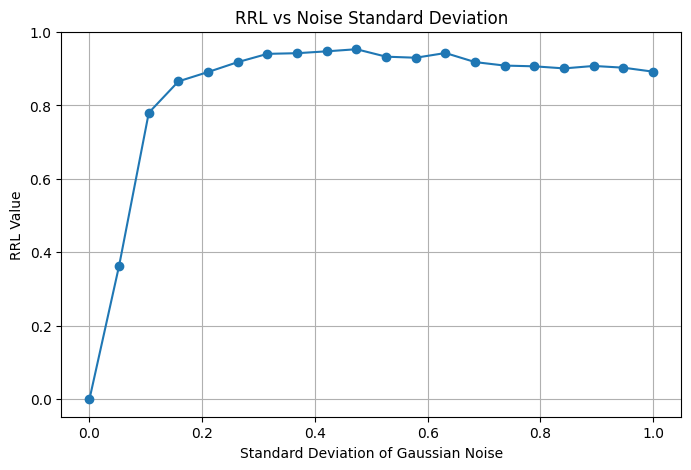

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have:
# y_pred_noisy_probs_list_1, y_pred_noisy_probs_list, y_reference_probs_list_1 (all lists of arrays of shape (samples, num_classes))
# and stddev_values (length 20)

rrl_values = []

for pred_noisy_1, pred_noisy, ref_probs in zip(y_pred_noisy_probs_list_1, y_pred_noisy_probs_list, y_reference_probs_list_1):
    # Compute numerator: l2 norm squared between pred_noisy_1 and ref_probs
    numerator = np.linalg.norm(pred_noisy_1 - ref_probs) ** 2

    # Compute denominator: l2 norm squared between pred_noisy and ref_probs
    denominator = np.linalg.norm(pred_noisy - ref_probs) ** 2

    # Compute RRL value
    rrl = numerator / denominator if denominator != 0 else np.nan
    rrl_values.append(rrl)

# Plot RRL vs Standard Deviation
plt.figure(figsize=(8, 5))
plt.plot(stddev_values, rrl_values, marker='o')
plt.xlabel('Standard Deviation of Gaussian Noise')
plt.ylabel('RRL Value')
plt.title('RRL vs Noise Standard Deviation')
plt.grid(True)
plt.show()


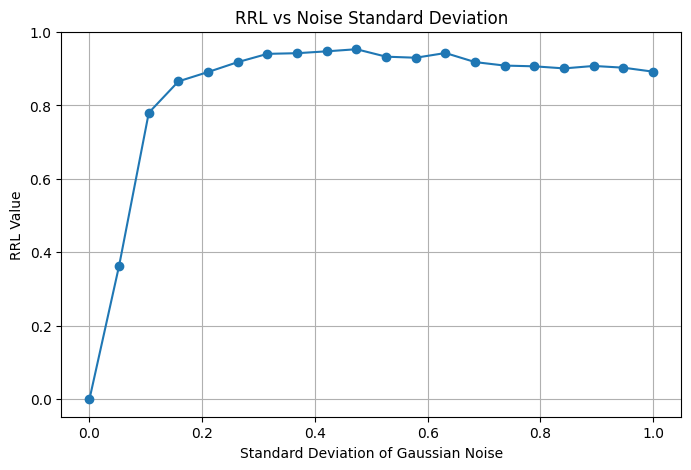

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have:
# y_pred_noisy_probs_list_1, y_pred_noisy_probs_list, y_reference_probs_list_1 (all lists of arrays of shape (samples, num_classes))
# and stddev_values (length 20)

rrl_values = []

for pred_noisy_1, pred_noisy, ref_probs in zip(y_pred_noisy_probs_list_1, y_pred_noisy_probs_list, y_reference_probs_list_1):
    # Compute numerator: l2 norm squared between pred_noisy_1 and ref_probs
    numerator = np.linalg.norm(pred_noisy_1 - ref_probs) ** 2

    # Compute denominator: l2 norm squared between pred_noisy and ref_probs
    denominator = np.linalg.norm(pred_noisy - ref_probs) ** 2

    # Compute RRL value
    rrl = numerator / denominator if denominator != 0 else np.nan
    rrl_values.append(rrl)

# Plot RRL vs Standard Deviation
fig = plt.figure(figsize=(8, 5))
plt.plot(stddev_values, rrl_values, marker='o')
plt.xlabel('Standard Deviation of Gaussian Noise')
plt.ylabel('RRL Value')
plt.title('RRL vs Noise Standard Deviation')
plt.grid(True)

# Save the figure as PDF before showing
fig.savefig('rrl_vs_noise_AIDS.pdf')

# Show the plot
plt.show()
